In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Đọc dữ liệu mới
df = pd.read_csv("Gold_Futures_Cleaned.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Chỉ lấy cột Price
data = df[['Price']].values

In [9]:
# Chuẩn hóa
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Tạo chuỗi thời gian
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)


In [10]:
# Tách train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Ngày tương ứng
train_dates = df['Date'][seq_length:seq_length+split].reset_index(drop=True)
test_dates = df['Date'][seq_length+split:].reset_index(drop=True)


In [11]:
# Xây mô hình GRU
model = Sequential()
model.add(GRU(64, return_sequences=False, input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)


c:\Users\admin\anaconda3\envs\myenv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0075
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 8.0017e-05
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.3716e-05
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.5603e-05
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.4518e-05
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.0699e-05
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 7.4400e-05
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 7.1720e-05
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.4335e-05
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 5.4765e-05
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 6.0157e-05
Epoch 12/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.5530e-05
Epoch 13/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 6.2526e-05
Epoch 14/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 5.8414e-05
Epoch

In [12]:
# Dự đoán
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)
train_inv = scaler.inverse_transform(y_train)


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [13]:
# === Tính toán các độ đo ===
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2 = r2_score(y_test_inv, y_pred_inv)

print("MAE:", mae)
print("MAPE:", mape)
print("RMSE:", rmse)
print("R2 Score:", r2)


MAE: 16.748655959944475
MAPE: 0.7434846474277088
RMSE: 23.774563672112407
R2 Score: 0.9968732715627421


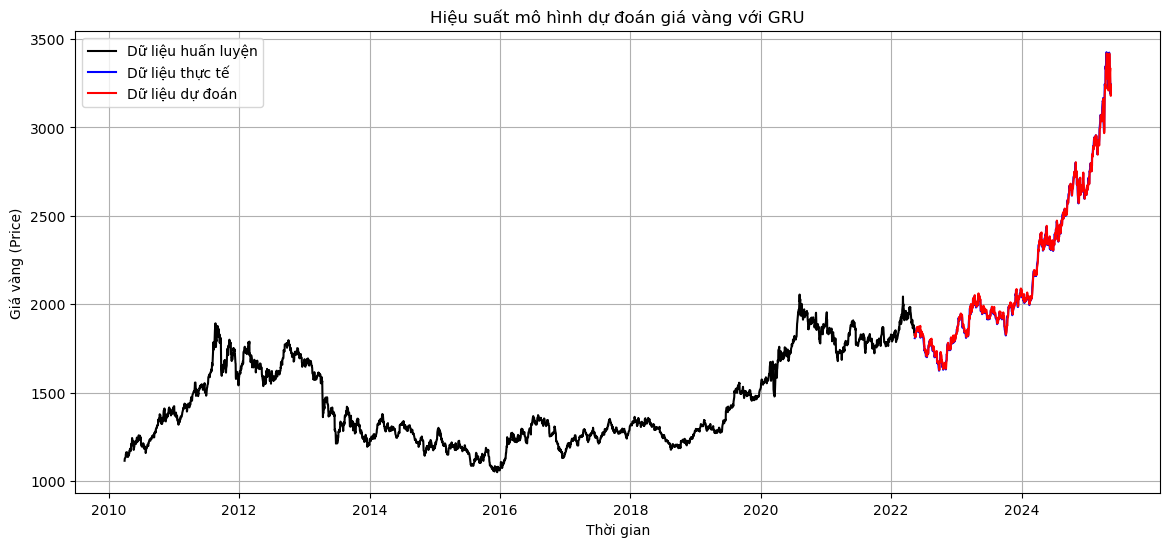

In [14]:
# === Vẽ biểu đồ ===
plt.figure(figsize=(14, 6))
plt.plot(train_dates, train_inv, label='Dữ liệu huấn luyện', color='black')
plt.plot(test_dates, y_test_inv, label='Dữ liệu thực tế', color='blue')
plt.plot(test_dates, y_pred_inv, label='Dữ liệu dự đoán', color='red')
plt.title('Hiệu suất mô hình dự đoán giá vàng với GRU')
plt.xlabel('Thời gian')
plt.ylabel('Giá vàng (Price)')
plt.legend()
plt.grid()

years = pd.to_datetime([f'{y}-01-01' for y in range(2010, 2026, 2)])
plt.xticks(ticks=years, labels=[str(y.year) for y in years])

plt.show()
